In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

In [3]:
#load the model
model = tf.keras.models.load_model('s_trained_model.keras')

In [4]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_69 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_71 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                 

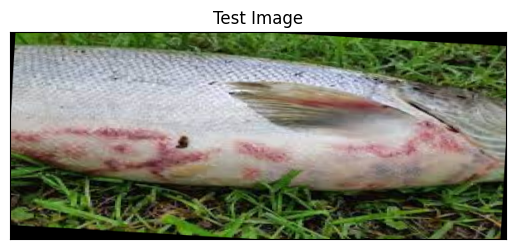

In [65]:
#visualizing image of our test set
image_path = r"D:\salmon\salmon_dataset_split\test\InfectedFish\infected_145.png"
img = cv2.imread(image_path) #read image
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #convert BGR to RGB

#displaying the image
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title("Test Image")
plt.show()

In [66]:
#testing model
image = tf.keras.preprocessing.image.load_img(image_path,target_size=[128,128])
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr]) #convert single image to a batch
print(input_arr.shape)

(1, 128, 128, 3)


In [67]:
prediction = model.predict(input_arr)[0][0]
prediction , prediction.shape

1/1 [==============================] - 0s 45ms/step


(0.74791163, ())

In [68]:
predicted_class = 1 if prediction >= 0.5 else 0

In [69]:
class_names = ['FreshFish', 'InfectedFish']

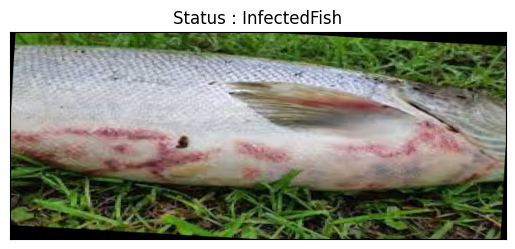

In [70]:
#displaying result
model_prediction = class_names[predicted_class]
plt.imshow(img)
#displaying the image
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title(f"Status : {model_prediction}")
plt.show()

In [71]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.__class__.__name__)


0 conv2d_68 Conv2D
1 conv2d_69 Conv2D
2 max_pooling2d_34 MaxPooling2D
3 conv2d_70 Conv2D
4 conv2d_71 Conv2D
5 max_pooling2d_35 MaxPooling2D
6 conv2d_72 Conv2D
7 conv2d_73 Conv2D
8 max_pooling2d_36 MaxPooling2D
9 conv2d_74 Conv2D
10 conv2d_75 Conv2D
11 max_pooling2d_37 MaxPooling2D
12 conv2d_76 Conv2D
13 conv2d_77 Conv2D
14 max_pooling2d_38 MaxPooling2D
15 flatten_8 Flatten
16 dense_16 Dense
17 dense_17 Dense


In [72]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_index):
    # Get the last conv layer by index
    last_conv_layer = model.layers[last_conv_layer_index].name

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean of gradients across height & width
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


In [73]:
# Pass your model and layer index
heatmap = make_gradcam_heatmap(input_arr, model, last_conv_layer_index=13)

In [ ]:
def display_gradcam_opencv(image_path, heatmap, alpha=0.4, threshold=0.5):
    # Load original image
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Resizing heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))

    # Apply color map
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    #overlay
    overlay = cv2.addWeighted(original, 1 - alpha, heatmap_colored, alpha, 0)

    # Threshold heatmap to create binary mask
    a , binary_mask = cv2.threshold(heatmap_resized, threshold, 1.0, cv2.THRESH_BINARY)
    binary_mask = np.uint8(255 * binary_mask)

    # Find contours
    contours, a = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #bounding box
    overlay_with_boxes = overlay.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlay_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2) 
        label = f"Infected Area"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        thickness = 1
        label_color = (255, 255, 255)  # White text
        cv2.putText(overlay_with_boxes, label, (x+3, y + 15), font, font_scale, label_color, thickness, cv2.LINE_AA)

    #to show vertical 
    combined = np.vstack([
        original,
        heatmap_colored,
        overlay_with_boxes
    ])

    # Display
    cv2.imshow("Grad-cam Image", cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return combined 

result = display_gradcam_opencv(image_path, heatmap, alpha=0.4, threshold=0.5)


In [54]:
cv2.imwrite("fish_no340.jpg",cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
print("Image Saved")

Image Saved
